In [68]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from matplotlib import pyplot as plt

import itertools

from setup import get_task_data

In [87]:
pd.plotting.register_matplotlib_converters()
TASK_DATA_NAME = 'AMD.csv'

df = pd.read_csv(get_task_data(TASK_DATA_NAME))

df.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume
9632,2018-05-25,13.4000,13.720000,13.3600,13.5400,13.5400,43850100
2917,1991-09-30,4.6875,4.750000,4.3125,4.6875,4.6875,2460000
2806,1991-04-23,6.2500,6.437500,6.2500,6.4375,6.4375,3197000
561,1982-06-07,0.0000,3.833333,3.6875,3.8125,3.8125,195000
3118,1992-07-16,4.3750,4.500000,4.3750,4.4375,4.4375,1810200


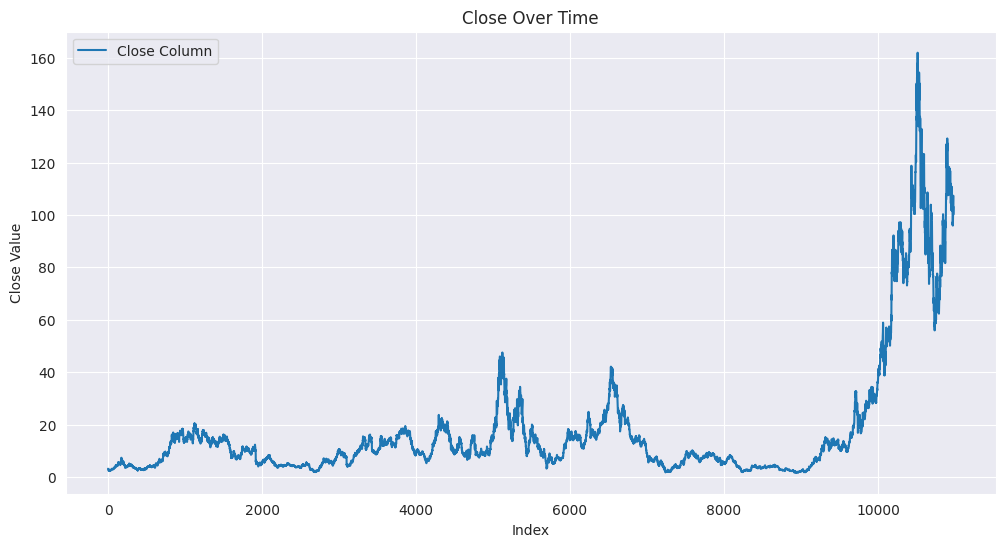

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Column')
plt.title('Close Over Time')
plt.xlabel('Index')
plt.ylabel('Close Value')
plt.legend()
plt.show()


df = df.iloc[10000:].reset_index() # IMPORTANT! getting recent data (based on chart)

In [71]:
def check_stationarity(ts):
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

check_stationarity(df['Close'])


ADF Statistic: -2.2768475196055245
p-value: 0.17954385670642464
Critical Values: {'1%': -3.4370266558635914, '5%': -2.864487711945291, '10%': -2.5683395116993872}


The ADF test is a statistical test for testing the stationarity of a time series. The test hypothesis is as follows:

Null Hypothesis (H0): The time series has a unit root (it is non-stationary).
Alternative Hypothesis (H1): The time series does not have a unit root (it is stationary).
The ADF test statistic is compared against critical values at different significance levels (1%, 5%, and 10%) to determine whether to reject the null hypothesis.

Analyzing our results, :
1) The ADF statistic is less than the critical values at all significance levels. This suggests that we don't have enough evidence to reject the null hypothesis.

2) The p-value is much higher than common significance levels (e.g., 0.05). A high p-value also suggests that we don't have enough evidence to reject the null hypothesis.

Critical Values: The ADF statistic is not more extreme than the critical values at any significance level.

So, Close column data is not stationary.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

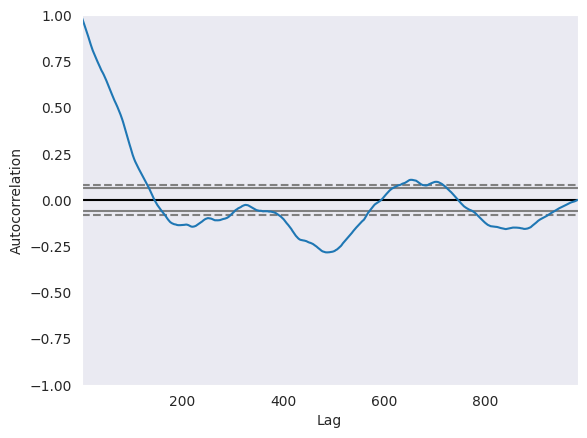

In [72]:
pd.plotting.autocorrelation_plot(df['Close'])

This chart shows us that there is a positive correlation with the first 600-650 lags, 
from which approximately 30-40 may be a good parameter(AR) for ARIMA.

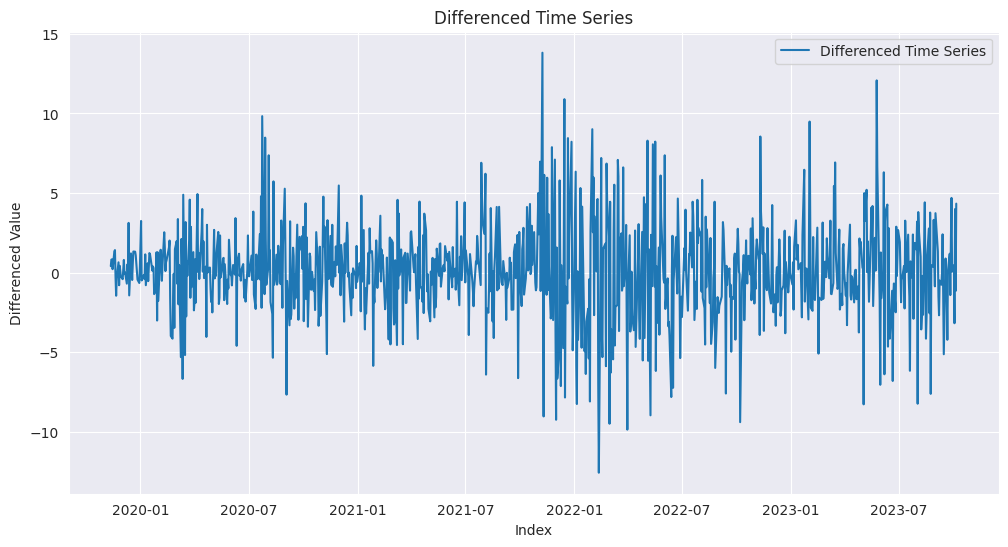

ADF Statistic: -32.57996864740656
p-value: 0.0
Critical Values: {'1%': -3.4370334797663844, '5%': -2.8644907213150725, '10%': -2.568341114581742}


In [73]:
diff_ts = df.set_index(pd.DatetimeIndex(df['Date']).to_period('d'))['Close'].diff().dropna()# Differencing to make the time series stationary
plt.figure(figsize=(12, 6))
plt.plot(diff_ts.index.to_timestamp(), diff_ts, label='Differenced Time Series')
plt.title('Differenced Time Series')
plt.xlabel('Index')
plt.ylabel('Differenced Value')
plt.legend()
plt.show()
check_stationarity(diff_ts)

As we can see, data is stationary now:
ADF Statistic: The ADF statistic is significantly lower than the critical values at all significance levels (1%, 5%, and 10%). This suggests strong evidence against the null hypothesis, indicating that you can reject the idea of a unit root, and the differenced time series is likely stationary.

BUILDING ARIMA Model

In [74]:
size = int(len(diff_ts) * 0.66)
train, test = diff_ts[0:size], diff_ts[size:len(diff_ts)]

Tuning:

In [75]:
p_values = range(5, 51, 15)
q_values = range(0, 5)

best_aic = float("inf")
best_bic = float("inf")
best_p, best_q = None, None
best_model = None

for p, q in itertools.product(p_values, q_values):
    model = ARIMA(train, order=(p, 1, q))
    model_fit = model.fit()
    aic = model_fit.aic
    bic=model_fit.bic
    print(f'\nHaving p,q = {p, q}, aic = {aic}, bic = {bic}\n')
    if aic <= best_aic and bic <= best_bic:
        best_aic, best_bic = aic, bic
        best_p, best_q = p, q
        best_model = model_fit

print(f"Best AIC: {best_aic}, Best BIC: {best_bic}")
print(f"Best (p, q) values: {best_p, best_q}")


Having p,q = (5, 0), aic = 3383.1295831142543, bic = 3409.96366088126

Having p,q = (5, 1), aic = 3284.965643687084, bic = 3316.2720677485904


/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (5, 2), aic = 3284.84738105467, bic = 3320.6261514106773

Having p,q = (5, 3), aic = 3280.195632634235, bic = 3320.4467492847434


/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (5, 4), aic = 3282.5772403505907, bic = 3327.3007032955998

Having p,q = (20, 0), aic = 3323.309439025037, bic = 3417.228711209556


/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (20, 1), aic = 3299.8258449399364, bic = 3398.217463418956


/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (20, 2), aic = 3301.9804121982124, bic = 3404.8443769717333


/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (20, 3), aic = 3302.9644486625302, bic = 3410.300759730552


/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (20, 4), aic = 3297.343959347372, bic = 3409.1526167098946

Having p,q = (35, 0), aic = 3315.42890259332, bic = 3476.4333691953525


/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (35, 1), aic = 3305.130396110286, bic = 3470.607209006819


/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (35, 2), aic = 3306.9696528744985, bic = 3476.9188120655326


/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (35, 3), aic = 3307.138297491, bic = 3481.5598029765347


/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (35, 4), aic = 3308.8504330714777, bic = 3487.744284851514

Having p,q = (50, 0), aic = 3321.5911092041697, bic = 3549.6807702237156


/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (50, 1), aic = 3313.7177926609793, bic = 3546.279799975026


/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (50, 2), aic = 3316.1895065796175, bic = 3553.2238601881654


/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (50, 3), aic = 3316.9718141142002, bic = 3558.478514017249


/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/volodymyr/.local/share/virtualenvs/exploratory_data_analysis---dPJcag/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (50, 4), aic = 3318.973703498067, bic = 3564.9527496956166

Best AIC: 3284.965643687084, Best BIC: 3316.2720677485904
Best (p, q) values: (5, 1)


We got a density plot of the residual error values, suggesting the errors are Gaussian.

We tuned model and got d-parameter from best L1 (0) score.
For p and q params, we used for loop over their combiations to find the best ones.
Picking the right hyperparameters can significantly impact model's performance.



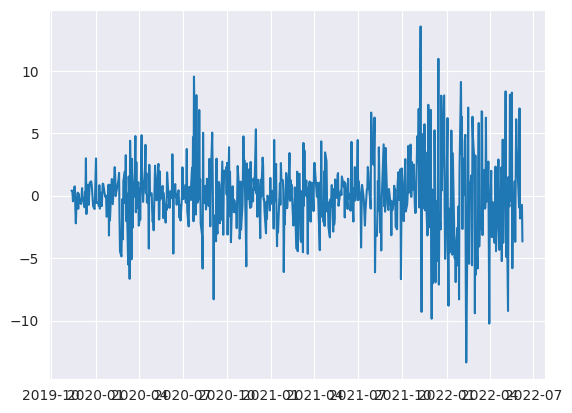

In [84]:
residuals = best_model.resid.set_axis(best_model.resid.index.to_timestamp())
plt.plot(residuals)
plt.show()

In [76]:
def mean_squared_error(df, actual_col, predicted_col):
    mse = np.mean((df[actual_col] - df[predicted_col]) ** 2)
    return mse

def mean_absolute_error(df, actual_col, predicted_col):
    mae = np.mean(np.abs(df[actual_col] - df[predicted_col]))
    return mae

def root_mean_squared_error(df, actual_col, predicted_col):
    rmse = np.sqrt(mean_squared_error(df, actual_col, predicted_col))
    return rmse

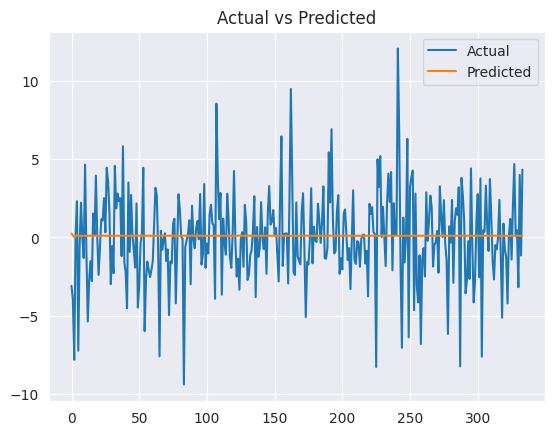

In [103]:
predictions = best_model.forecast(steps=len(test))
results = pd.DataFrame({'Actual': test, 'Predicted': predictions.set_axis(test.index)}).reset_index()

plt.plot(results['Actual'], label='Actual')
plt.plot(results['Predicted'], label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

In [79]:
results['Actual_scaled'] = (results['Actual'] - results['Actual'].min()) / (results['Actual'].max() - results['Actual'].min())
results['Predicted_scaled'] = (results['Predicted'] - results['Predicted'].min()) / (results['Predicted'].max() - results['Predicted'].min())
mse_value = mean_squared_error(results, 'Actual_scaled', 'Predicted_scaled')
mae_value = mean_absolute_error(results, 'Actual_scaled', 'Predicted_scaled')
rmse_value = root_mean_squared_error(results, 'Actual_scaled', 'Predicted_scaled')

print(f'Mean Squared Error: {mse_value}')
print(f'Mean Absolute Error: {mae_value}')
print(f'Root Mean Squared Error: {rmse_value}')

Mean Squared Error: 0.022240945060766418
Mean Absolute Error: 0.11120207537165097
Root Mean Squared Error: 0.14913398358780072


Analyzing model performance, we got quite decent results for such a messy data.

MSE: The MSE is relatively low, suggesting that, on average, the squared differences between actual and predicted values are small. This is a positive indication of model performance.

MAE: The MAE is also relatively low, indicating that, on average, the absolute differences between actual and predicted values are small. Again, this is a positive sign.

RMSE: The RMSE is similar to the MAE but considers larger errors more heavily due to the squaring. The fact that RMSE is close to MAE suggests that there are not many large errors in the predictions.